In [273]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import nxviz as nv
from itertools import count

# Анализ степени взаимодействия студентов

На факультете свободных искусств и наук у студентов нет групп и нет потоковых лекций, но они пересекаются и соприкасаются друг с другом, что колледж становится общим потоком. 

## Вопросы
 - Описать структуру взаимодействия студентов
 - Насколько студенты реально пересекаются?
 - Возможно ли выведением нескольких курсов минимизировать пересечения? 

In [213]:
# Read the data (credits to Arseny Khakhalin from Bard College)
filename = 'Courses.xls'
dfd = pd.read_excel(filename, sheet_name=None) # Read all pages in a dict, in a horrible format
#names = [(df.iloc[0,1], df.iloc[2,1].split(' ')[0], df.iloc[3,1], df.iloc[10:]) for key,df in dfd.items()]
course_name, instructor, course_type = list(zip(*[(df.iloc[0,1], df.iloc[2,1].split(' ')[0], df.iloc[3,1]) for key,df in dfd.items()]))
# Names will be course name + last name of the professor
# (As for some courses we have several sections, and no obvious id to distinguish them)

dfd = pd.read_excel(filename, sheet_name=None, header=10) # Read all pages in a dict, in a good format
i = 0
for key,val in dfd.items():
    val['course_name'] = course_name[i]
    val['instructor'] = instructor[i]
    val['course_type'] = course_type[i]


    if i == 0:
        df = val
    else:
        df = pd.concat((df, val), axis=0)
    i += 1
    
df.columns = ['N', 'id', 'Student', 'Area', 'Group', 'Course', 'Instructor', 'Course_Type']
df = df.drop(['Student','Group'], axis=1) # Drop names and extra info

,N,id,Area,Course,Instructor,Course_Type
0,1,st079017,2 курс,А.Н. Скрябин и его мир (на английском языке),Орлов,E200
1,2,st062182,4 курс,А.Н. Скрябин и его мир (на английском языке),Орлов,E200
0,1,st063046,3 курс,Абстрактная алгебра,Жукова,E300
1,2,st075659,2 курс,Абстрактная алгебра,Жукова,E300
2,3,st076760,2 курс,Абстрактная алгебра,Жукова,E300
...,...,...,...,...,...,...
13,14,st062652,4 курс,"Языки музыки: элементы, структуры, смыслы",Харьковский,C300
14,15,st062182,4 курс,"Языки музыки: элементы, структуры, смыслы",Харьковский,C300
15,16,st071487,3 курс,"Языки музыки: элементы, структуры, смыслы",Харьковский,C300
16,17,st033844,3 курс,"Языки музыки: элементы, структуры, смыслы",Харьковский,C300


In [214]:
df.head()

,N,id,Area,Course,Instructor,Course_Type
0,1,st079017,2 курс,А.Н. Скрябин и его мир (на английском языке),Орлов,E200
1,2,st062182,4 курс,А.Н. Скрябин и его мир (на английском языке),Орлов,E200
0,1,st063046,3 курс,Абстрактная алгебра,Жукова,E300
1,2,st075659,2 курс,Абстрактная алгебра,Жукова,E300
2,3,st076760,2 курс,Абстрактная алгебра,Жукова,E300


## Методы
Студенты  записываются на курсы в соответствии с учебным планом. Считаем что студенты взаимодейтсвуют друг с другом, если они записаны на один курс.
Моделью такого взаимодействия может быть двудольный граф, в котором есть два набора игроков: студенты и курсы, и связи студент - курс. Свойства такого графа и будем изучать. Еще есть момент, что один преподаватель может читать несколько курсов, так что взаимодействие в реальности еще плотнее. Но, считаем, что преподаватели ответственные, в противогазах и студента к себе не то что на 1.5 метра не подпускают, а на пушечный выстрел. 

In [268]:
G = nx.Graph()
for i in range(df.shape[0]):
    course = df.Course.iloc[i]
    id = df.id.iloc[i]
    G.add_node(course, bipartite='courses', instructor = df.Instructor.iloc[i], c_type = df.Course_Type.iloc[i])
    G.add_node(id,bipartite='students', area = df.Area.iloc[i])
    G.add_edge(course, id)

##  Визуализация
Хочется оценить степень пересечений студентов визуально. Ничего не видно на всей выборке, сделаем на случайной выборке студентов. 

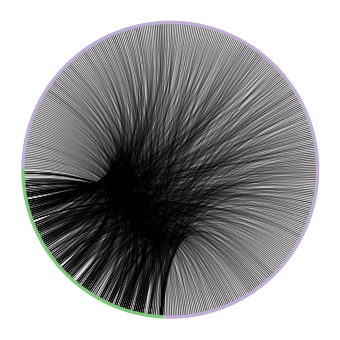

In [269]:
c = nv.CircosPlot(G, node_color='bipartite', node_grouping='bipartite')
c.draw()

In [290]:
def get_node_colors(G, attr_name):
    groups = set(nx.get_node_attributes(G,attr_name).values())
    mapping = dict(zip(sorted(groups),count()))
    nodes = G.nodes()
    colors = [mapping[G.nodes[n][attr_name]] for n in nodes]
    return colors

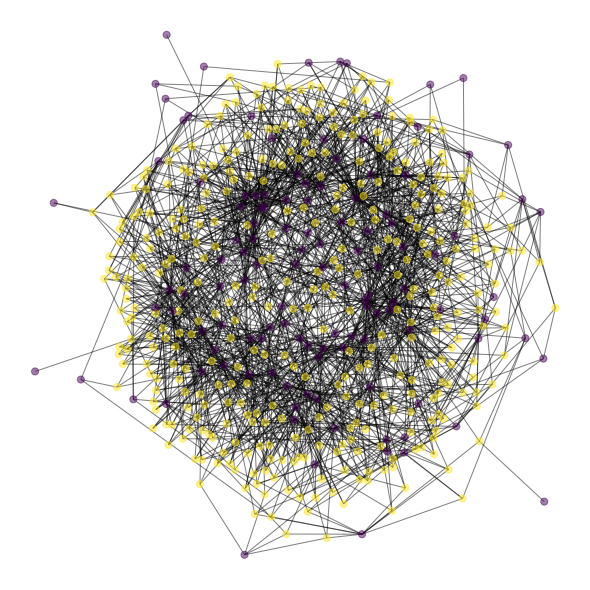

In [293]:
plt.figure(figsize=(8,8))
node_color = get_node_colors(G, 'bipartite')
nx.draw_kamada_kawai(G, node_size=50, alpha=0.5, node_color=node_color)

In [358]:
def sel_random_courses(number = 10):
    course_list = pd.unique(df.Course)
    selected = list(np.random.choice(course_list,number))
    selected = add_students(selected)
    return selected

def add_students(course_list):
    st_list = []
    for item in course_list:
        st_list.extend([n for n in G.neighbors(item)]) 
    st_list = list(set(st_list))
    course_list.extend(st_list)
    return course_list

def return_subgraph(G, course_list = None, number = 10, draw = True):
    if course_list is None:
        node_sel = sel_random_courses(number = 10)
    else:
        node_sel = add_students(course_list)
    G_small  = G.subgraph(node_sel)
       
        
    st_nodes = [n for n, d in G_small.nodes(data=True) if d['bipartite'] == 'students']
    cs_nodes = [n for n, d in G_small.nodes(data=True) if d['bipartite'] == 'courses']
    if draw:
        cs_nodes = [n for n, d in G_small.nodes(data=True) if d['bipartite'] == 'courses']
        pos = nx.bipartite_layout(G_small, cs_nodes)
        node_color = get_node_colors(G_small, 'bipartite')

        ec = nx.draw_networkx_edges(G_small, pos, alpha=0.2)
        nc = nx.draw_networkx_nodes(G_small, pos,  
                            with_labels=False, node_size=100, node_color=node_color, cmap='coolwarm')
        
    return G_small    



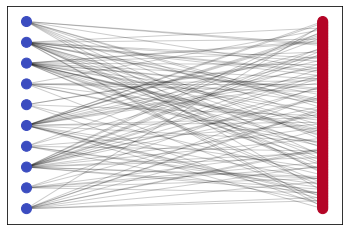

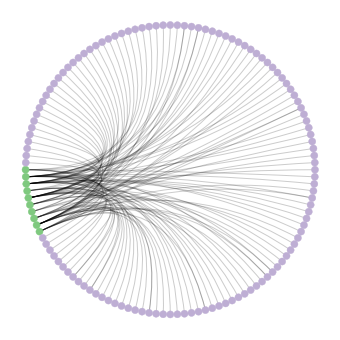

In [362]:
G_small = return_subgraph(G, number = 10, draw = True)
c = nv.CircosPlot(G_small, node_color='bipartite', node_grouping='bipartite')
c.draw()

## Граф взаимодействия студентов

Студенты записываются на курсы и основное взаимодействие осуществляется внутри курсов (блоки вдоль диагонали). Но при этом видим много внедиагональных элементов.

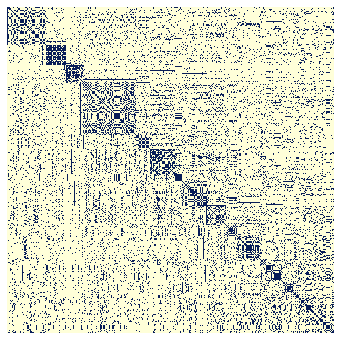

In [372]:
ap = nv.MatrixPlot(G_st)
ap.draw()

## Параметры взаимодействия студентов

In [364]:
st_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'students']
G_s = nx.bipartite.overlap_weighted_projected_graph(G,st_nodes)

### Small world
Обычно социальные связи представляют собой так называемый "тесный мир", в котором между любой парой человек можно установить связь через нескольких знакомых (отсюда же теория про 6 рукопожатий). В случае со студентами этот параметр оказался гораздо меньше. Даже если мы будем считать, что студенты общаются исключительно на занятиях, между каждой парой студентов среднее расстояние оказалось меньше двойки. То есть, даже если за эту неделю студенты не успевают пообщаться друг с другом напрямую, между ними будет не более одного посредника, при этом взаимодействие осуществляется чаще напрямую, чем хотя бы через одного посредника

In [371]:
print(f" Средняя длина пути между каждой парой студентов: {nx.average_shortest_path_length(G_s):.2f}")

 Средняя длина пути между каждой парой студентов: 1.84


Посмотрим еще на распределение числа контактов, которые студенты успевают осуществить за неделю

Минимальное число встреч: 19, максимальное: 89, среднее: 60.19, медианное 61.0


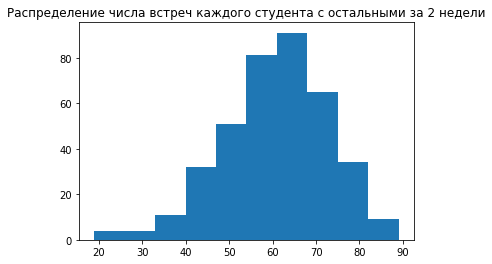

In [387]:
# Посчитаем для каждого студента число его соседей
degrees = [len(list(G_st.neighbors(n))) for n in G_st.nodes()]
plt.hist(degrees); plt.title('Распределение числа встреч каждого студента с остальными за 2 недели');
print(f"Минимальное число встреч: {min(degrees)}, максимальное: {max(degrees)}, среднее: {np.mean(degrees):.2f}, медианное {np.median(degrees)}")

## Выявление курсов суперспредеров


In [388]:
cs_nodes = [n for n, d in G.nodes(data=True) if d['bipartite'] == 'courses']
G_c = nx.bipartite.overlap_weighted_projected_graph(G,cs_nodes)

In [427]:
print(f"Всего в осеннем семестре будет читаться: {len(G_c.nodes())} курса")

Всего в осеннем семестре будет читаться: 123 курса


Посмотрим сначала самые важные курсы по числу взаимодействий. Здесь курсы связаны в том случае, если на них есть общие студенты. Число в данном случае, это количество других курсов, которые посетили студенты с этого курса. То есть если Маша сходила на когнитивную психологию и машинное обучение, а Вася на историю кино и политологию  - то число будет 4. В данном случае мы видим, что студенты курсов -лидеров посещают от 40 до 80 курсов в совокупности


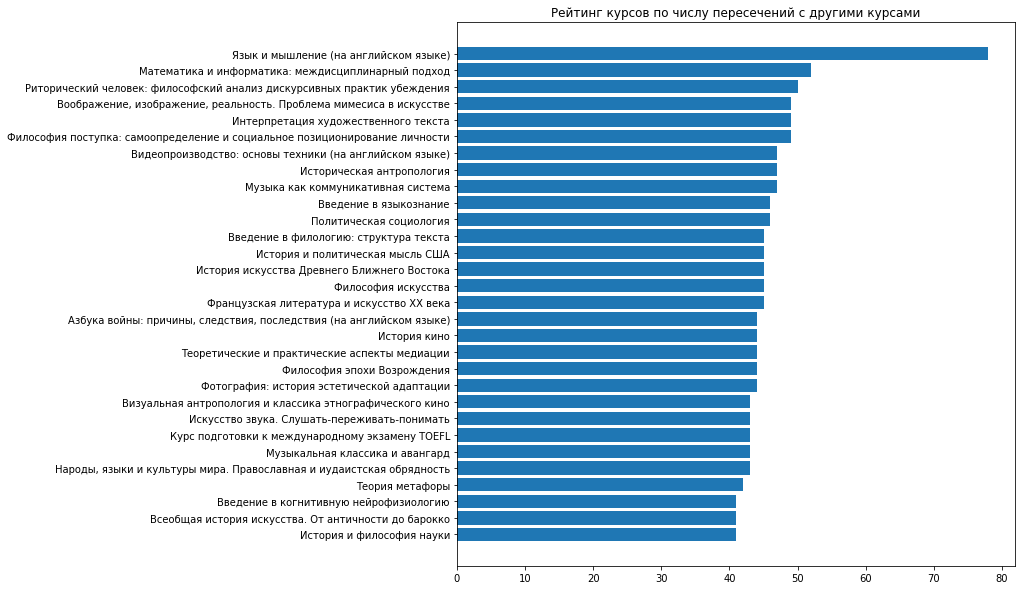

In [416]:
plt.figure(figsize  = (10,10))
degrees_courses = [len(list(G_c.neighbors(n))) for n in G_c.nodes()]
zipped = zip(G_c.nodes(),degrees_courses)
rtg_courses = sorted(zipped, key = lambda t: t[1], reverse=True)
num = 30
names, rtg = list(zip(*rtg_courses))
x_pos = np.arange(len(names))
plt.barh(x_pos[::-1][:num], rtg[:num],align='center')
plt.yticks(x_pos[::-1][:num], names[:num]); 
plt.title('Рейтинг курсов по числу пересечений с другими курсами');

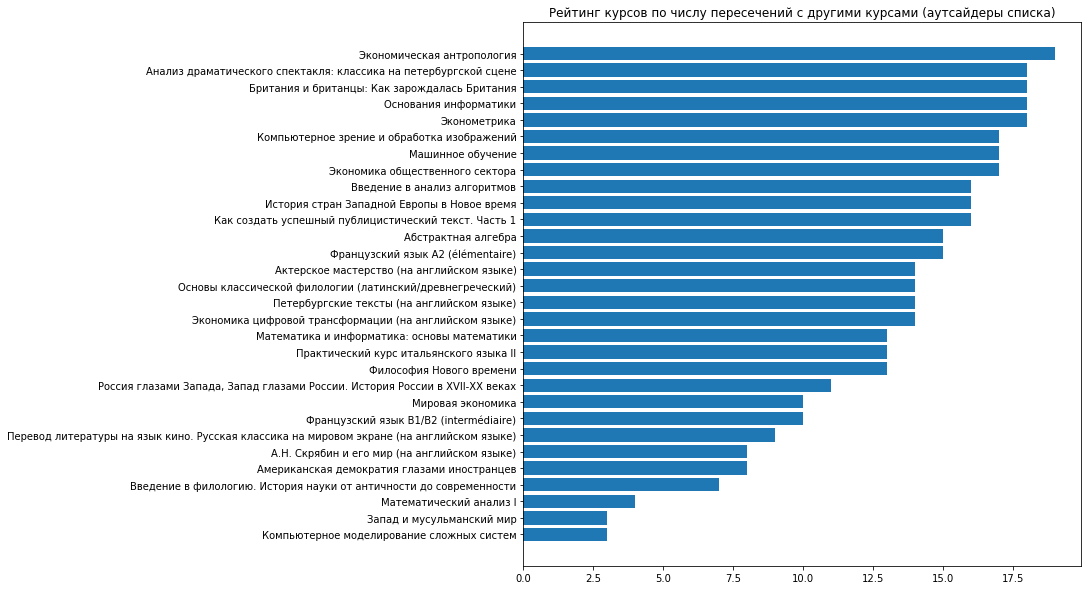

In [419]:
plt.figure(figsize  = (10,10))
plt.barh(x_pos[::-1][-num:], rtg[-num:],align='center')
plt.yticks(x_pos[::-1][-num:], names[-num:]); 
plt.title('Рейтинг курсов по числу пересечений с другими курсами (аутсайдеры списка)');

Выявим курсы, которые наиболее сильно влияют на коммуникацию между студентами.
Для этого сделаем отдельный граф, в котором соединим между собой курсы, в том случае если на них присутствуют одни и те же студенты,чем больше пересечение студентов, тем больше будет вес ребра между курсами. Сделаем это с помощью следующей метрики коммуникации:

 - communicability_betweenness_centrality (доля любых возможных путей, проходящих через данный узел)
 
 
Отдельно выделяется Язык и мышление, курс общего профиля, которые объединяет наиболее разнородный состав студентов. Однако дальше мы видим очень медленный спад по курсам, что говорит о том, что выведением какого-то одного или нескольких курсов проблему распространения вируса, если он появится не решить  

In [424]:
def draw_rating(cent, num = 30):
    plt.figure(figsize = (10,10))
    
    c_sorted = sorted(cent, key=cent.get, reverse=True)
    values = [cent[w] for w in c_sorted]
    x_pos = np.arange(len(values))

    plt.barh(x_pos[::-1][:num], values[:num],align='center')
    plt.yticks(x_pos[::-1][:num], c_sorted[:num]); 
    plt.title("Курсы-лидеры по осуществлению коммуникации между студентами ")
    
    plt.figure(figsize = (10,10))

    plt.barh(x_pos[::-1][:num], values[-num:],align='center')
    plt.yticks(x_pos[::-1][:num], c_sorted[-num:]); 
    plt.title("Курсы-аутсайдеры по осуществлению коммуникации между студентами ")
    
    

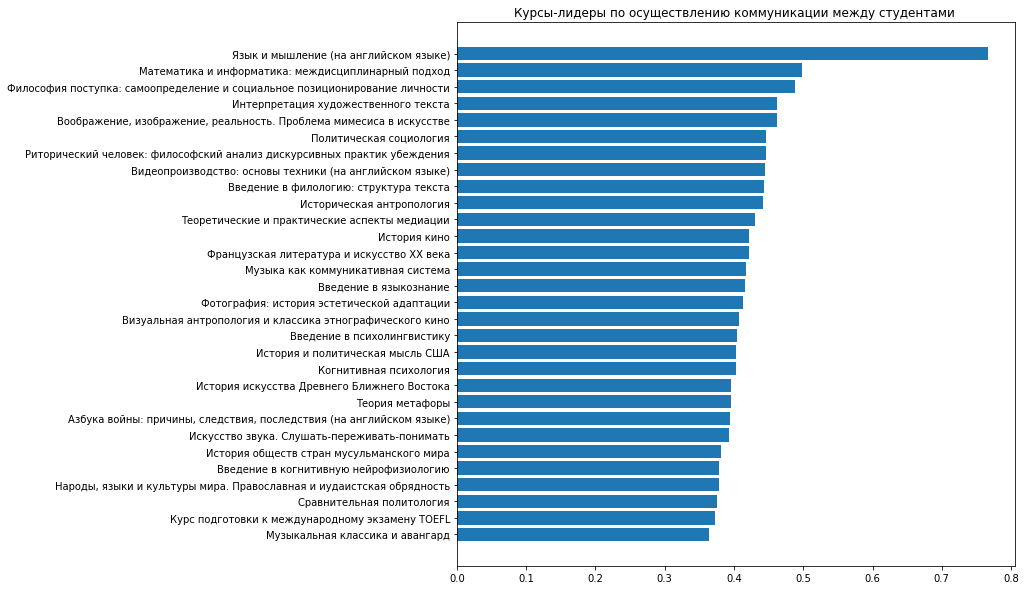

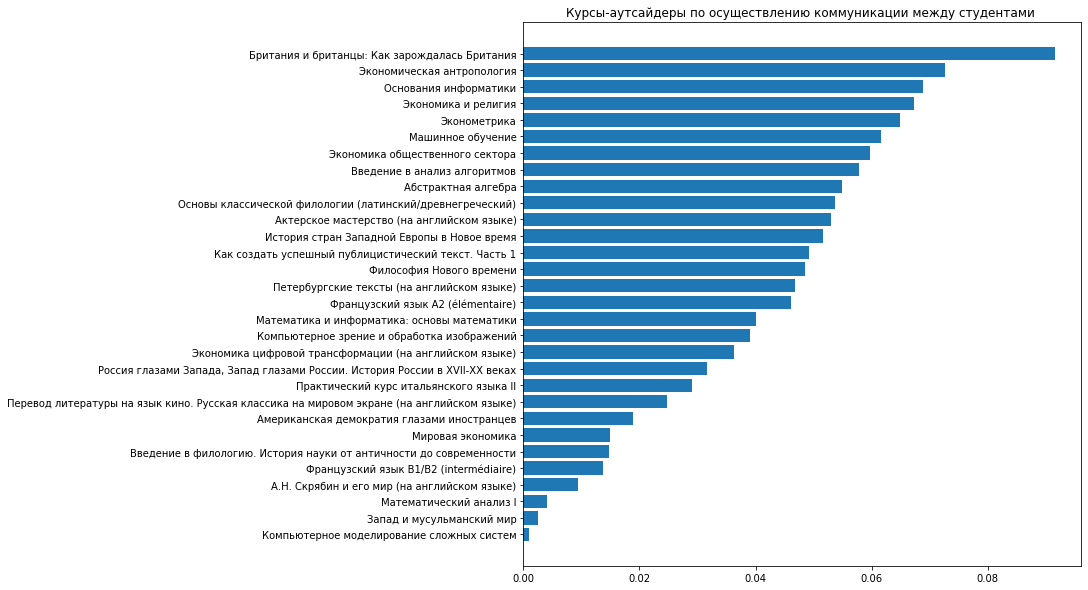

In [425]:
com_cent = nx.communicability_betweenness_centrality(G_c)
draw_rating(com_cent, num = 30)

В общем общий вывод такой, если мы хотим уменьшить значимо взаимодействие, то надо убрать 90% курсов